In [ ]:
# !nvidia-smi -L

In [ ]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-05-19 11:50:26--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-05-19 11:50:26 (119 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras import layers

def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

def load_and_prep_image(filename, img_shape=224):
    img = tf.io.read_file(filename)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, size=[img_shape, img_shape])
    img = img / 255.
    return img

def pred_and_plot(model, filename, class_names):
    img = load_and_prep_image(filename)
    pred = model.predict(tf.expand_dims(img, axis=0))
    pred_class_index = pred.argmax()

    if 0 <= pred_class_index < len(class_names):
        pred_class = list(class_names.keys())[list(class_names.values()).index(pred_class_index)]
    else:
        pred_class = "Unknown"

    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

def create_base_model(input_shape=(224, 224, 3), output_shape=10, learning_rate=0.001, training=False):
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
    base_model.trainable = training

    inputs = layers.Input(shape=input_shape, name="input_layer")
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
    outputs = layers.Dense(units=output_shape, activation="softmax", name="output_layer")(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy"])
    return model

def compare_historys(original_history, new_history, initial_epochs=5):
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]
    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]
    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

###Data

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
# Get all available datasets in TFDS
datasets_list = tfds.list_builders()

# Set our target dataset and see if it exists
target_dataset = "food101"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

'food101' in TensorFlow Datasets: True


In [ ]:
#Load data
(train_data,test_data),ds_info = tfds.load(name=target_dataset,split=["train","validation"],as_supervised=True,with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.R2XV13_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.R2XV13_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features["label"].names
class_names[:20]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla']

In [ ]:
class_names[:]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [ ]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 56
  Class name (str form): huevos_rancheros
        


In [ ]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
tf.reduce_min(image),tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

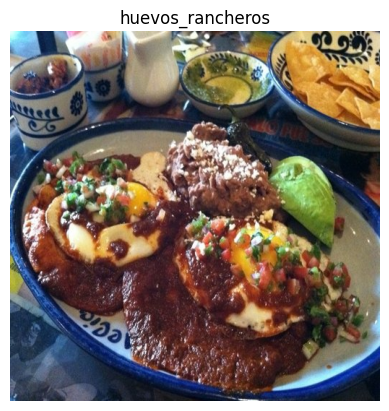

In [ ]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

In [ ]:
def show_random_sample(dataset, class_names):
    sample = dataset.shuffle(1000).take(1)
    for image, label in sample:
        plt.imshow(image.numpy())
        plt.title(class_names[label.numpy()])
        plt.axis(False)
        print(f"Class label: {label.numpy()} ({class_names[label.numpy()]})")


In [ ]:
show_random_sample(train_data, class_names)

###Preprocessing Function

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[230.65816 253.64285 251.     ]
  [222.99998 254.97449 252.19388]
  [207.06633 255.      250.36734]
  ...
  [140.66287 129.52519 121.22428]
  [121.14268 115.26515 116.95397]
  [ 83.95363  83.08119  89.63737]]

 [[221.47449 254.37755 253.33163]
  [214.5102  255.      253.92348]
  [198.41327 254.58673 251.96939]
  ...
  [208.66318 195.82143 173.40823]
  [197.03056 190.1071  174.83162]
  [175.54036 171.6169  161.21384]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

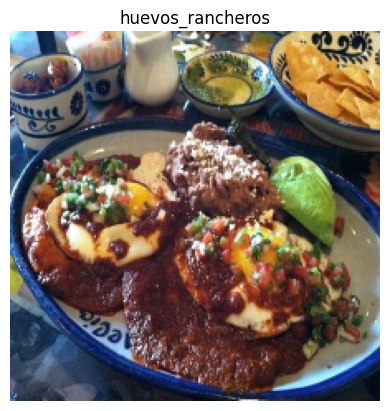

In [ ]:
# We can still plot our preprocessed image as long as we
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False)

In [ ]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# train_data = (train_data
#               .unbatch()                     # remove the accidental batch axis
#               .map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
#               .shuffle(1000)
#               .batch(32)                     # exactly one batch step
#               .prefetch(tf.data.AUTOTUNE))

In [ ]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [ ]:
print(image.shape)

(512, 512, 3)


In [ ]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback
import tensorflow as tf # Ensure tensorflow is imported for callbacks

# Create ModelCheckpoint callback to save model's progress
# saving weights requires ".weights.h5" extension when save_weights_only=True
checkpoint_path = "model_checkpoints/cp.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

##Mixed Precision Training

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

In [ ]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

##Feature extraction model

In [ ]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20250519-104437
Epoch 1/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 207s 74ms/step - accuracy: 0.4763 - loss: 2.2865 - val_accuracy: 0.6957 - val_loss: 1.1399
Epoch 2/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 163s 65ms/step - accuracy: 0.6626 - loss: 1.3037 - val_accuracy: 0.7177 - val_loss: 1.0362
Epoch 3/3
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 163s 68ms/step - accuracy: 0.6999 - loss: 1.1550 - val_accuracy: 0.7283 - val_loss: 0.9948


In [ ]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 52s 65ms/step - accuracy: 0.7242 - loss: 1.0093


[1.0086102485656738, 0.7257821559906006]

In [ ]:
def create_model():
  # Create base model
  input_shape = (224, 224, 3)
  base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
  base_model.trainable = False # freeze base model layers

  # Create Functional model
  inputs = layers.Input(shape=input_shape, name="input_layer")
  # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
  # x = layers.Rescaling(1./255)(x)
  x = base_model(inputs, training=False) # set base_model to inference mode only
  x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
  x = layers.Dense(len(class_names))(x) # want one output neuron per class
  # Separate activation of output layer so we can output float32 activations
  outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
  model = tf.keras.Model(inputs, outputs)

  return model

# 2. Create and compile a new version of the original model (new weights)
created_model = create_model()
created_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# 3. Load the saved weights
created_model.load_weights(checkpoint_path)

# 4. Evaluate the model with loaded weights
results_created_model_with_loaded_weights = created_model.evaluate(test_data)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 4 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 63ms/step - accuracy: 0.7242 - loss: 1.0093


In [ ]:
# # 5. Loaded checkpoint weights should return very similar results to checkpoint weights prior to saving
# import numpy as np
# assert np.isclose(results_feature_extract_model, results_created_model_with_loaded_weights).all(), "Loaded weights results are not close to original model."  # check if all elements in array are close

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
# Provide a filepath with a .keras extension when saving the entire model (save_best_only=True)
checkpoint_path = "fine_tune_checkpoints/best_model.keras"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [ ]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [ ]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [ ]:
# # Start to fine-tune (all layers)
# history_101_food_classes_all_data_fine_tune = model.fit(train_data,
#                                                         epochs=100, # fine-tune for a maximum of 100 epochs
#                                                         steps_per_epoch=len(train_data),
#                                                         validation_data=test_data,
#                                                         validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
#                                                         callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
#                                                                    model_checkpoint, # save only the best model during training
#                                                                    early_stopping, # stop model after X epochs of no improvements
#                                                                    reduce_lr]) # reduce the learning rate after X epochs of no improvements

In [ ]:
model.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 51s 64ms/step - accuracy: 0.7399 - loss: 0.9466


[0.9424147009849548, 0.7437227964401245]

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, mixed_precision
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)
from google.colab import drive

# ── 0. YOUR DATA & CLASSES ────────────────────────────────────────────────────
# Define these before running:
#   train_data: tf.data.Dataset of (image, label)
#   test_data:  tf.data.Dataset of (image, label)
#   class_names: list of 101 food-category strings

# ── 1. MOUNT DRIVE & CREATE SAVE DIR ─────────────────────────────────────────
drive.mount('/content/drive', force_remount=True)
SAVE_DIR = '/content/drive/MyDrive/food_vision/07_efficientnetb0_fine_tuned_101_classes_mixed_precision'
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs('fine_tune_checkpoints', exist_ok=True)  # for intermediate ckpts

# ── 2. SPEED: MIXED PRECISION & XLA JIT ───────────────────────────────────────
mixed_precision.set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)

# ── 3. DATA PIPELINE: TF.DATA + AUGMENTATION ─────────────────────────────────
BATCH_SIZE = 64    # T4 has 16 GB VRAM; increase if you can
IMG_SIZE   = 224

augment_layers = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

def preprocess(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

def make_ds(dataset, shuffle=False, augment=False):
    ds = dataset
    if shuffle:
        ds = ds.shuffle(2048)
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        ds = ds.map(
            lambda x, y: (augment_layers(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = make_ds(train_data, shuffle=True,  augment=True)
val_ds   = make_ds(test_data,   shuffle=False, augment=False)

# ── 4. MODEL BUILDING ─────────────────────────────────────────────────────────
def create_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    base   = tf.keras.applications.EfficientNetB0(
        include_top=False,
        input_tensor=inputs,
        weights='imagenet'
    )
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(num_classes)(x)
    outputs = layers.Activation('softmax', dtype='float32')(x)
    return tf.keras.Model(inputs, outputs), base

model, backbone = create_model(len(class_names))

# ── 5. FEATURE-EXTRACTION: TRAIN ONLY THE HEAD ───────────────────────────────
backbone.trainable = False
opt_head = AdamW(learning_rate=1e-3, weight_decay=1e-5)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(label_smoothing=0.1),
    optimizer=opt_head,
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=2,
            min_delta=1e-3,
            restore_best_weights=True
        )
    ]
)

# ── 6. FINE-TUNING: PROGRESSIVE UNFREEZING ────────────────────────────────────
for layer in backbone.layers[-30:]:
    layer.trainable = True

steps_per_epoch = len(train_data) // BATCH_SIZE
total_steps     = steps_per_epoch * 50

lr_schedule = CosineDecayRestarts(
    initial_learning_rate=1e-4,
    first_decay_steps=total_steps // 5
)

opt_ft = AdamW(learning_rate=lr_schedule, weight_decay=1e-6)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(label_smoothing=0.1),
    optimizer=opt_ft,
    metrics=['accuracy']
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=3,
            min_delta=1e-3,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            filepath=os.path.join('fine_tune_checkpoints', 'best_model.keras'),
            save_best_only=True,
            monitor='val_loss',
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=2,
            verbose=1,
            min_lr=1e-7
        )
    ]
)

# ── 7. SAVE FINAL WEIGHTS ─────────────────────────────────────────────────────
model.save_weights(os.path.join(SAVE_DIR, 'efficientnetb0_101_finetuned.ckpt'))
print(f'Training complete, weights saved to: {SAVE_DIR}')


Mounted at /content/drive


NameError: name 'train_data' is not defined